In [1]:
import numpy as np 
import pandas as pd
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Embedding, LSTM, Dense,GlobalAveragePooling1D, Dropout,Bidirectional

In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/novel_classification/open/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/novel_classification/open/test_x.csv')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_data.head()

In [ ]:
train_data.info()

In [ ]:
train_data.head()

In [ ]:
# 특수문자 제거
train_data['clean_text'] = train_data['text'].str.replace("[^a-zA-Z]"," ")
test_data['clean_text'] = test_data['text'].str.replace("[^a-zA-Z]"," ")

#전체 단어 소문자 변환
train_data['clean_text'] = train_data['clean_text'].apply(lambda x : x.lower())
test_data['clean_text'] = test_data['clean_text'].apply(lambda x : x.lower())

#중복값 제거
train_data.drop_duplicates(subset=['clean_text'], inplace=True)
#test_data.drop_duplicates(subset=['clean_text'], inplace=True)

#아무것도 없는 값 제거?


In [ ]:
print(train_data['text'].nunique())
print(len(train_data))

54484
54484


In [ ]:
test_data.head()

,index,text,clean_text
0,0,“Not at all. I think she is one of the most ch...,not at all i think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""...",no replied he with sudden consciousness ...
2,2,As the lady had stated her intention of scream...,as the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...,and then suddenly in the silence i heard a so...
4,4,His conviction remained unchanged. So far as I...,his conviction remained unchanged so far as i...


In [ ]:
train_data.head()

,index,text,author,clean_text
0,0,"He was almost choking. There was so much, so m...",3,he was almost choking there was so much so m...
1,1,"“Your sister asked for it, I suppose?”",2,your sister asked for it i suppose
2,2,"She was engaged one day as she walked, in per...",1,she was engaged one day as she walked in per...
3,3,"The captain was in the porch, keeping himself ...",4,the captain was in the porch keeping himself ...
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3,have mercy gentlemen odin flung up his han...


In [ ]:
pre_X_train= train_data['clean_text']
y_train= train_data['author']
pre_X_test = test_data['clean_text']

In [ ]:
print("pre_X_train 길이 ", len(pre_X_train))
print("pre_X_test 길이 ", len(pre_X_test))
print("labels 정답 개수", y_train.nunique())

pre_X_train 길이  54484
pre_X_test 길이  19617
labels 정답 개수 5


In [ ]:
# 불용어 제거하는 모듈 불러오기
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 불용어 제거하는 함수 만들기
def remove_stopwords(text_list):
  whole_list = []
  for str in text_list :
    str_list = []
    for w in str.split():
      if w not in stop_words : 
        str_list.append(w)
    str_list = " ".join(str_list)
    whole_list.append(str_list)
  return whole_list

In [ ]:
# 불용어 제거 함수 호출하기
X_train = remove_stopwords(pre_X_train)
X_test = remove_stopwords(pre_X_test)

In [ ]:
print(X_train[3])
print(len(X_train))

captain porch keeping carefully way treacherous shot intended turned spoke us doctor watch lookout dr odin take north side please jim east gray west watch hands load muskets lively men careful
54484


In [ ]:
print(X_test[0])
print(len(X_test))

think one charming young ladies ever met might useful work decided genius way witness way preserved agra plan papers father love emotional thing whatever emotional opposed true cold reason place things never marry lest bias judgment
19617


In [ ]:
# tokenizer 1차 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
sequences_train = tokenizer.texts_to_sequences(X_train)
print(sequences_train[:5])

[[134, 7272, 19, 19, 307, 18, 219, 3091, 32, 444, 2682, 1196, 5040, 1694, 1109, 41, 55, 1, 1177, 2815], [180, 56, 213], [671, 3, 37, 248, 12920, 435, 34, 187, 4435, 4756, 1212, 435, 619, 496, 701, 492, 5, 1, 79, 89, 1, 665, 856, 46, 187, 420, 5375, 281, 2], [239, 5041, 870, 1232, 35, 8423, 742, 1508, 115, 249, 21, 146, 592, 10862, 511, 1, 61, 1577, 122, 396, 2048, 1633, 1727, 1397, 592, 101, 3694, 6441, 1912, 124, 1768], [1334, 325, 1, 1547, 101, 485, 1475, 935, 2070, 96, 6442, 4025, 898, 16094, 6975, 9494, 73, 168]]


In [ ]:
sequences_test = tokenizer.texts_to_sequences(X_test)
print(sequences_test[:5])

[[20, 3, 1396, 60, 516, 74, 330, 38, 1789, 226, 842, 2469, 35, 1243, 35, 3246, 8848, 1103, 642, 81, 129, 13288, 100, 541, 13288, 3781, 224, 336, 266, 99, 178, 22, 641, 2126, 20934, 1433], [108, 433, 1383, 141, 156, 2179, 1434, 2369, 268, 4, 947, 6, 10, 9, 10768], [102, 3488, 1231, 3497, 125, 4, 2647, 5248, 7710, 3700, 2941, 2827, 3665, 2522, 72, 1049, 80, 5, 1, 3276, 19, 12554, 547, 3359, 92, 23237, 33, 2026, 2740, 1722, 1761], [105, 279, 80, 390, 353, 96, 597, 21001, 19673, 19581, 28394, 17480, 171, 4939, 226, 896, 53, 148, 8, 526, 1077, 2556, 13467, 164, 79, 230, 2437, 214, 8, 600, 13386, 398, 120, 91, 902, 16, 254, 393, 12856, 14557, 20188, 744, 3497, 72, 2136, 3151, 1833, 5618, 1, 70, 15774, 10925, 19673, 5203, 1208, 2437, 489, 26, 63, 41, 9800, 6, 268, 289, 1131, 2427, 2056, 77, 847, 273, 4, 1626, 19, 8, 520, 330, 185, 45, 1560, 4, 15, 8, 8290, 3657, 20, 765, 6147, 2800, 35, 90, 69, 4687, 596, 65, 2590, 230, 894, 6512, 8, 177, 1034, 416, 5703, 329, 539, 64, 158, 13695, 162, 42, 96

In [ ]:

word_to_index = tokenizer.word_index
print(len(word_to_index))
index_to_word = tokenizer.index_word
print(len(index_to_word))

33505
33505


In [ ]:
# 단어의 등장빈도 확인하기
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
print('등장 빈도가 {}번 이상인 단어의 수 {}'.format(threshold, (total_cnt-rare_cnt)))
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 2번 이상인 단어의 수 23218
등장 빈도가 1번 이하인 희귀 단어의 수: 10287
단어 집합(vocabulary)에서 희귀 단어의 비율: 30.702880167139234
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.9650057598282934


In [ ]:
#tokenizer 2차 생성
vocab_size=total_cnt - rare_cnt+1
print(vocab_size)
tokenizer2 = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

23219


In [ ]:
tokenizer2.fit_on_texts(X_train)

In [ ]:
sequences_train = tokenizer2.texts_to_sequences(X_train)
print(sequences_train[:5])
sequences_test = tokenizer2.texts_to_sequences(X_test)
print(sequences_test[:5])

[[135, 7273, 20, 20, 308, 19, 220, 3092, 33, 445, 2683, 1197, 5041, 1695, 1110, 42, 56, 2, 1178, 2816], [181, 57, 214], [672, 4, 38, 249, 12921, 436, 35, 188, 4436, 4757, 1213, 436, 620, 497, 702, 493, 6, 2, 80, 90, 2, 666, 857, 47, 188, 421, 5376, 282, 3], [240, 5042, 871, 1233, 36, 8424, 743, 1509, 116, 250, 22, 147, 593, 10863, 512, 2, 62, 1578, 123, 397, 2049, 1634, 1728, 1398, 593, 102, 3695, 6442, 1913, 125, 1769], [1335, 326, 2, 1548, 102, 486, 1476, 936, 2071, 97, 6443, 4026, 899, 16095, 6976, 9495, 74, 169]]
[[21, 4, 1397, 61, 517, 75, 331, 39, 1790, 227, 843, 2470, 36, 1244, 36, 3247, 8849, 1104, 643, 82, 130, 13289, 101, 542, 13289, 3782, 225, 337, 267, 100, 179, 23, 642, 2127, 20935, 1434], [109, 434, 1384, 142, 157, 2180, 1435, 2370, 269, 5, 948, 7, 11, 10, 10769], [103, 3489, 1232, 3498, 126, 5, 2648, 5249, 7711, 3701, 2942, 2828, 3666, 2523, 73, 1050, 81, 6, 2, 3277, 20, 12555, 548, 3360, 93, 1, 34, 2027, 2741, 1723, 1762], [106, 280, 81, 391, 354, 97, 598, 21002, 19674,

In [ ]:
word_to_index = tokenizer2.word_index
index_to_word = tokenizer2.index_word
print(len(word_to_index))
print(len(index_to_word))

33506
33506


메일의 최대 길이 : 212
메일의 평균 길이 : 19.565450


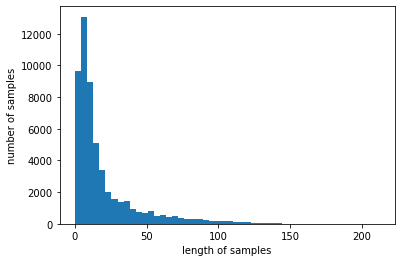

In [ ]:
# 최대길이 평균길이 구하기
%matplotlib inline
import matplotlib.pyplot as plt

X_data = sequences_train
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
#파라미터 설정
max_len = 215
embedding_dim = 16
max_length = max_len
padding_type = 'post'

In [ ]:
# 패딩하기

X_train_pad = pad_sequences(sequences_train, maxlen=max_len,padding=padding_type)
X_test_pad = pad_sequences(sequences_test, maxlen=max_len, padding=padding_type)

In [ ]:
print(X_train_pad)

[[  135  7273    20 ...     0     0     0]
 [  181    57   214 ...     0     0     0]
 [  672     4    38 ...     0     0     0]
 ...
 [ 2422    11 18716 ...     0     0     0]
 [  308  3552   153 ...     0     0     0]
 [  199   806     3 ...     0     0     0]]


In [ ]:
print(X_test_pad)

[[  21    4 1397 ...    0    0    0]
 [ 109  434 1384 ...    0    0    0]
 [ 103 3489 1232 ...    0    0    0]
 ...
 [   2  446 1612 ...    0    0    0]
 [ 107    9    2 ...    0    0    0]
 [ 571 6165    8 ...    0    0    0]]


In [ ]:
print("train 데이터 패딩 : {}".format(X_train_pad.shape))
print("test 데이터 패딩 : {}".format(X_test_pad.shape))

train 데이터 패딩 : (54484, 215)
test 데이터 패딩 : (19617, 215)


In [ ]:
# y값 원핫인코딩하기 -> 원핫인코딩을 하면 모델링에 문제가 생김
y_train_onehot = to_categorical(y_train)

In [ ]:
print("원핫 인코딩 전 y shape", y_train.shape)
print("원핫 인코딩 후 y shape", y_train_onehot.shape)
print(y_train[2])
print(y_train_onehot[2])

원핫 인코딩 전 y shape (54484,)
원핫 인코딩 후 y shape (54484, 5)
1
[0. 1. 0. 0. 0.]


In [ ]:
#텐서화 작업 필요 batch_size

In [ ]:
#모델 생성
"""
model = Sequential([
         Embedding(vocab_size, embedding_dim, input_length= max_length),
         GlobalAveragePooling1D(),
         Dense(24, activation='relu'),
         Dense(5, activation='softmax')
])
"""

model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.7)),
    Bidirectional(LSTM(64,dropout=0.7)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(5, activation='softmax'),
])


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#model.summary()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 215, 16)           371504    
_________________________________________________________________
bidirectional (Bidirectional (None, 215, 128)          41472     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 516,533
Trainable params: 516,533
Non-trainable params: 0
__________________________________________________

In [ ]:
epoch =20

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/novel_classification/my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(filepath = checkpoint_path, save_weights_only=True,
save_best_only = True, monitor = 'val_loss', verbose=1)

history = model.fit(X_train_pad, y_train, epochs=epoch, verbose=2, validation_split=0.1,
					callbacks=[checkpoint])

#checkpoint를 저장한 파일명을 입력 : 학습 종료후 다시 모델에 로드시켜준다.
model.load_weights(checkpoint_path)

Epoch 1/20
1533/1533 - 66s - loss: 1.3462 - accuracy: 0.4262 - val_loss: 1.1692 - val_accuracy: 0.5183

Epoch 00001: val_loss improved from inf to 1.16918, saving model to /content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/novel_classification/my_checkpoint.ckpt
Epoch 2/20
1533/1533 - 52s - loss: 1.0479 - accuracy: 0.5807 - val_loss: 0.8997 - val_accuracy: 0.6511

Epoch 00002: val_loss improved from 1.16918 to 0.89972, saving model to /content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/novel_classification/my_checkpoint.ckpt
Epoch 3/20
1533/1533 - 53s - loss: 0.8457 - accuracy: 0.6759 - val_loss: 0.8139 - val_accuracy: 0.6893

Epoch 00003: val_loss improved from 0.89972 to 0.81387, saving model to /content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/novel_classification/my_checkpoint.ckpt
Epoch 4/20
1533/1533 - 53s - loss: 0.7499 - accuracy: 0.7170 - val_loss: 0.7662 - val_accuracy: 0.7102

Epoch 00004: val_loss improved from 0.81387 to 0.76616, saving model to 

In [ ]:
# predict values
pred = model.predict_proba(X_test_pad)
pred

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[1.45105058e-02, 1.96389183e-01, 6.64112389e-01, 1.23056345e-01,
        1.93151250e-03],
       [1.22292764e-01, 2.06633732e-01, 2.43864655e-01, 1.11607507e-01,
        3.15601349e-01],
       [9.99393702e-01, 3.67717206e-04, 4.71298263e-05, 1.06103013e-04,
        8.52596568e-05],
       ...,
       [9.86596860e-05, 9.99728143e-01, 1.76773083e-05, 1.30770801e-04,
        2.46409145e-05],
       [1.38926771e-04, 9.99728739e-01, 2.21368282e-05, 8.36995023e-05,
        2.64129540e-05],
       [9.99691725e-01, 1.52446388e-04, 1.90837054e-05, 4.07720145e-05,
        9.60704783e-05]], dtype=float32)

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/novel_classification/open/sample_submission.csv', encoding = 'utf-8')
sample_submission[['0','1','2','3','4']] = pred


In [ ]:
sample_submission.to_csv('/content/drive/MyDrive/Colab Notebooks/dacon-ai-competition/novel_classification/submission1.csv', index = False, encoding = 'utf-8')